<a href="https://colab.research.google.com/github/alicmu2024/GNSS-Jamming-Detection-and-Classification-using-Machine-Learning-Deep-Learning-and-Computer-Vision/blob/main/Jamming_Detection_Base_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **`In the name of God!`**

0. Downloading the dataset, unzipping it and removing irrelevant files

In [ ]:
# Downloading The Dataset
%%capture
! wget https://zenodo.org/records/3783969/files/Jamming_Classifier.zip?download=1

In [ ]:
%%capture
%cp /content/Jamming_Classifier.zip?download=1 Jamming_Classifier.zip
! rm -rf /content/Jamming_Classifier.zip?download=1
! unzip ./Jamming_Classifier.zip
! rm -rf /content/energyop.m
! rm -rf /content/Channel
! rm -rf /content/Classifier
! rm -rf /content/Detector_Functions
! rm -rf /content/GNSS_signals
! rm -rf /content/Init
! rm -rf /content/Jammer_signals
! rm -rf /content/Misc
! rm -rf /content/Plotting
! rm -rf /content/Progress_Bar
! rm -rf /content/Sim
! rm -rf /content/Test_statistic
! rm -rf /content/CNN_algorithm.m
! rm -rf /content/Jamming_Classifier.zip
! rm -rf /content/SVM_algorithm.m
! rm -rf /content/SVM_algorithm2.m
! rm -rf /content/Testing_CNR_JSR.mat
! rm -rf /content/Training_CNR_JSR.mat
! rm -rf /content/energyop.m
! rm -rf /content/main.m
! rm -rf /content/main_test_classifiers.m
! rm -rf /content/parfor_progress_percentage.txt
! rm -rf /content/plotConfMat.m
! rm -rf /content/stopIfAccuracyNotImproving.m

In [ ]:
import os
import torch
import torchvision
import torch.nn as nn
import numpy as np

import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid

import random
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [ ]:
data_dir = '.'
data_dir = str(data_dir)

In [ ]:
classes = os.listdir(data_dir + "/Image_training_database")
print(classes)

['SingleAM', 'SingleChirp', 'NB', 'NoJam', 'SingleFM', 'DME']


In [ ]:
classes = os.listdir(data_dir + "/Image_testing_database")
print(classes)

['SingleAM', 'SingleChirp', 'NB', 'NoJam', 'SingleFM', 'DME']


In [ ]:
def show_images(dataset='train'):
    next_pix= []
    # Parameters for our graph; we'll output images in a 5x2 configuration
    nrows = 5
    ncols = 2

    fig = plt.gcf()
    fig.set_size_inches(ncols * 5, nrows * 5)
    for i in range(len(classes)):
        next_pix.append(os.path.join(data_dir,dataset,classes[i]))
        img = mpimg.imread(os.path.join(next_pix[i],random.choice(os.listdir(next_pix[i]))))
        # Set up subplot; subplot indices start at 1
        sp = plt.subplot(nrows, ncols, i + 1)
        sp.axis('Off') # Don't show axes (or gridlines)
        plt.imshow(img)
        plt.title(classes[i])

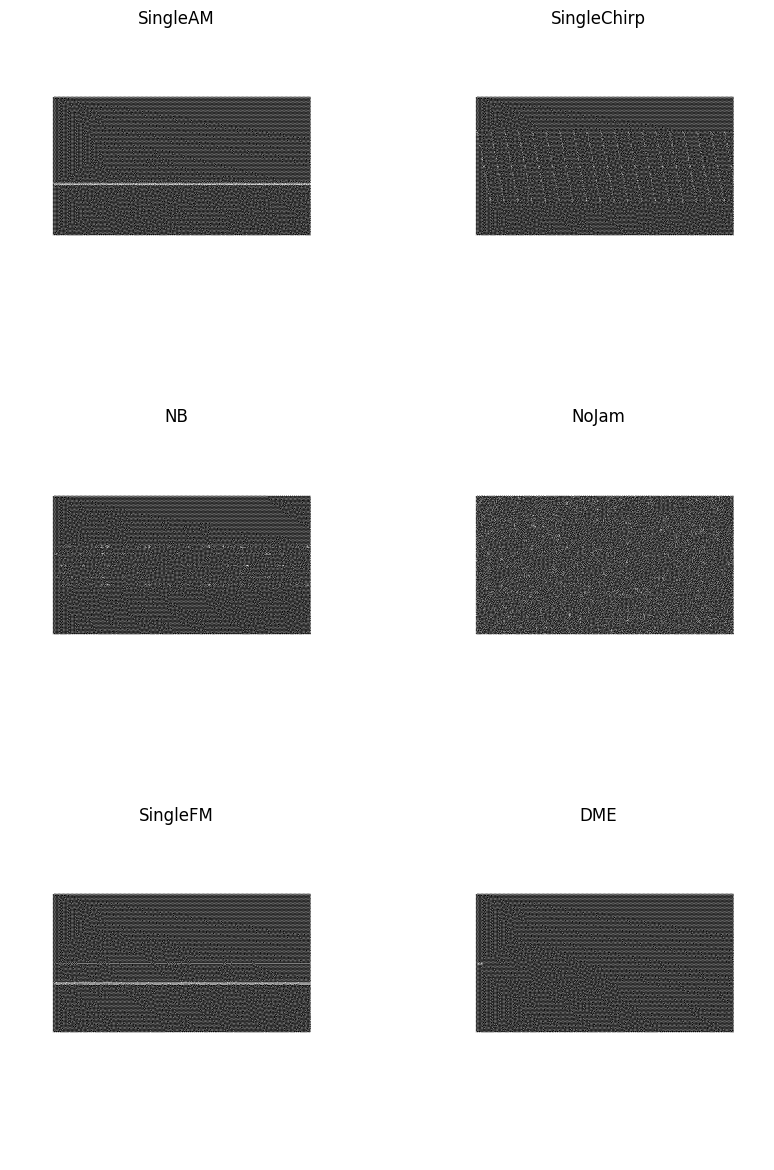

In [ ]:
# showing training images
show_images('./Image_training_database')

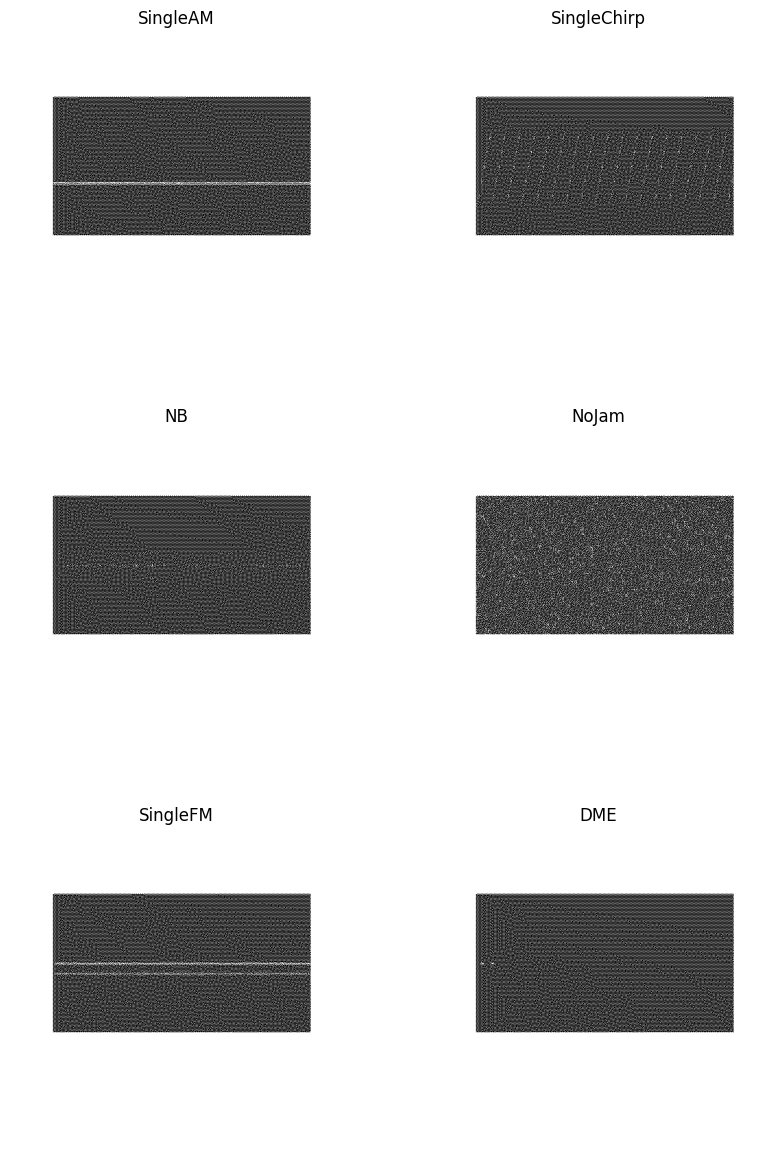

In [ ]:
# showing training images
show_images('./Image_testing_database')

In [ ]:
train_dir = '/content/Image_training_database'
test_dir = '/content/Image_testing_database'

train_dataset = ImageFolder(train_dir, transform=tt.ToTensor())
test_dataset = ImageFolder(test_dir, transform=tt.ToTensor())

train_dataloader = DataLoader(train_dataset, batch_size=32)
test_dataloader = DataLoader(test_dataset, batch_size=64)

In [ ]:
for image, _ in train_dataloader:
  print(image.shape)
  break

torch.Size([32, 3, 512, 512])


In [ ]:
def get_mean_and_std(dataloader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in dataloader:
        # Mean over batch, height and width, but not over the channels
        channels_sum += torch.mean(data, dim=[0,2,3])
        channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
        num_batches += 1

    mean = channels_sum / num_batches

    # std = sqrt(E[X^2] - (E[X])^2)
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5
    print(channels_sum,channels_squared_sum,num_batches)
    return mean, std

In [ ]:
# print(get_mean_and_std(train_dataloader))

In [ ]:
from torch.utils.data import  random_split


# Data transforms (normalization & data augmentation)
stats = ((0.7582, 0.7582, 0.7582), (0.4282, 0.4282, 0.4282))
train_tfms = tt.Compose([
    tt.Resize(128),
    tt.ToTensor(),
    tt.Normalize(*stats, inplace=True)])

valid_tfms = tt.Compose([
    tt.Resize(128),
    tt.ToTensor(),
    tt.Normalize(*stats)])

# PyTorch datasets
train_ds = ImageFolder(train_dir, train_tfms)
valid_ds = ImageFolder(test_dir, valid_tfms)

# Split validation dataset into validation and test datasets (50-50)
valid_size = len(valid_ds)
val_split = valid_size // 2  # Calculate the split size
test_split = valid_size - val_split  # Ensure all samples are used

valid_ds, test_ds = random_split(valid_ds, [val_split, test_split])

# PyTorch data loaders
batch_size = 32
train_dl = DataLoader(train_ds,
                      batch_size,
                      shuffle=True,
                      num_workers=2,
                      pin_memory=True)

valid_dl = DataLoader(valid_ds,
                      batch_size,
                      num_workers=2,
                      pin_memory=True)

test_dl = DataLoader(test_ds,
                     batch_size,
                     num_workers=2,
                     pin_memory=True)

# Now you have train_dl, valid_dl, and test_dl ready for use

In [ ]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(30, 30))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images, nrow=8).permute(1, 2, 0).clamp(0,1))
        break

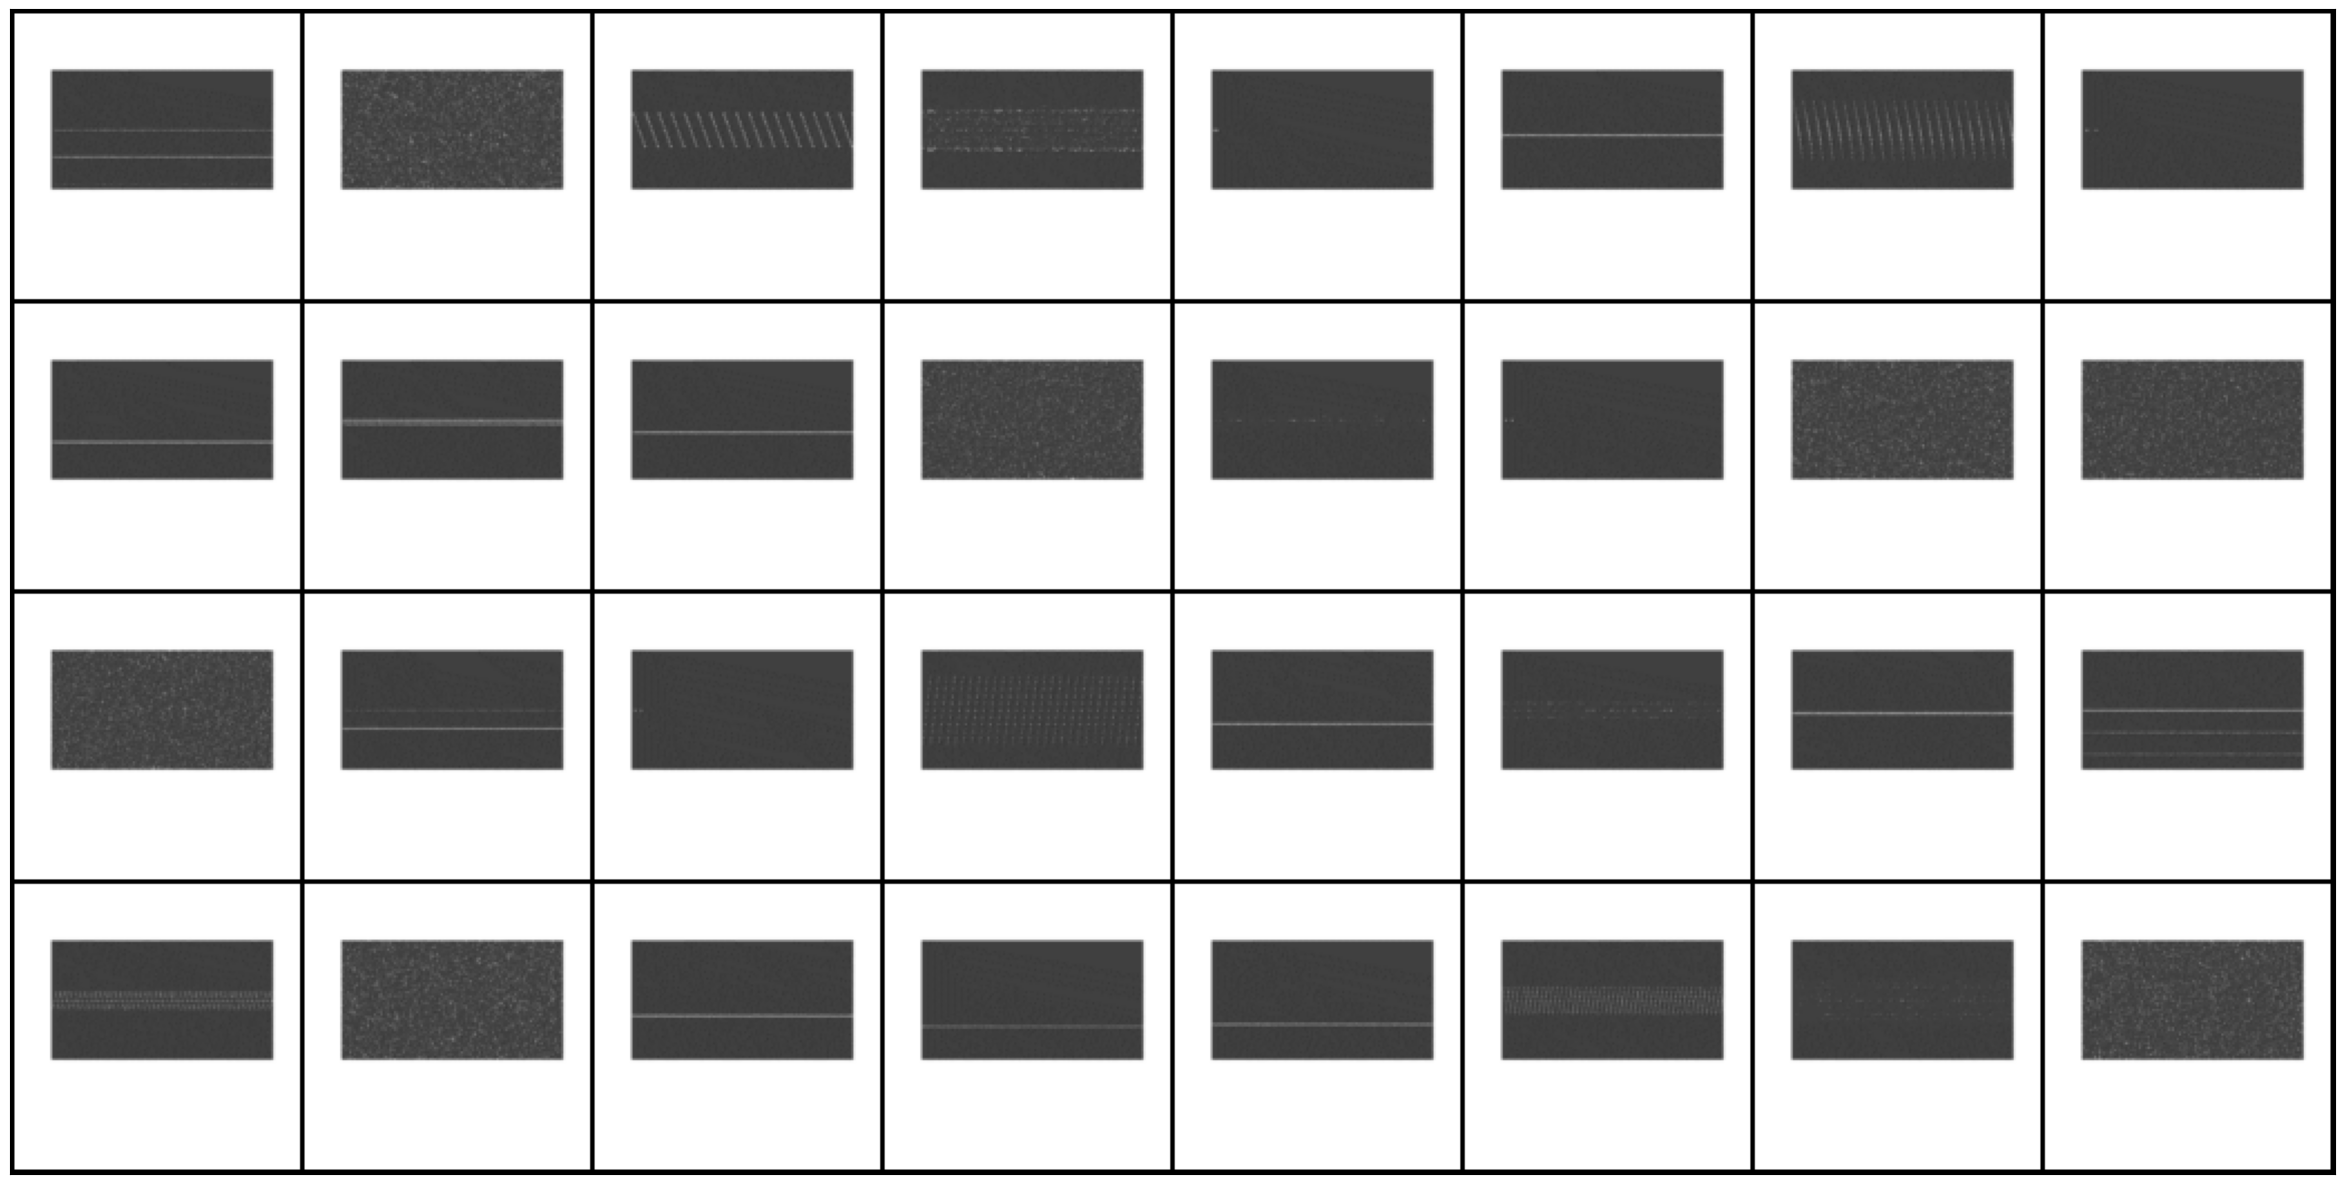

In [ ]:
show_batch(test_dl)

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)


In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss,
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch + 1, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
for batch in train_dl:
  images, labels = batch
  print(images.shape)
  # print(labels)
  break

torch.Size([32, 3, 128, 128])


In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))

        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))

        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d((1,1)),
                                        nn.Flatten(),
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [ ]:
model = ResNet9(3, len(classes))

In [ ]:
%%capture
! pip install torchinfo

In [ ]:
from torchinfo import summary
summary(model, input_size=(batch_size, 3, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet9                                  [32, 6]                   --
├─Sequential: 1-1                        [32, 64, 128, 128]        --
│    └─Conv2d: 2-1                       [32, 64, 128, 128]        1,792
│    └─BatchNorm2d: 2-2                  [32, 64, 128, 128]        128
│    └─ReLU: 2-3                         [32, 64, 128, 128]        --
├─Sequential: 1-2                        [32, 128, 64, 64]         --
│    └─Conv2d: 2-4                       [32, 128, 128, 128]       73,856
│    └─BatchNorm2d: 2-5                  [32, 128, 128, 128]       256
│    └─ReLU: 2-6                         [32, 128, 128, 128]       --
│    └─MaxPool2d: 2-7                    [32, 128, 64, 64]         --
├─Sequential: 1-3                        [32, 128, 64, 64]         --
│    └─Sequential: 2-8                   [32, 128, 64, 64]         --
│    │    └─Conv2d: 3-1                  [32, 128, 64, 64]         147,584
│

In [ ]:
model = to_device(ResNet9(3, len(classes)), device)

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 1.7923275232315063, 'val_acc': 0.16684435307979584}]

In [ ]:
epochs = 10
max_lr = 0.002
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam
history=[]

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl,
                             grad_clip=grad_clip,
                             weight_decay=weight_decay,
                             opt_func=opt_func)

Epoch [1], last_lr: 0.00056, train_loss: 0.2406, val_loss: 2.1618, val_acc: 0.6197
Epoch [2], last_lr: 0.00152, train_loss: 0.1618, val_loss: 3.5477, val_acc: 0.4026
Epoch [3], last_lr: 0.00200, train_loss: 0.1738, val_loss: 0.8063, val_acc: 0.7558
Epoch [4], last_lr: 0.00190, train_loss: 0.1237, val_loss: 0.2869, val_acc: 0.8685


In [ ]:
evaluate(model, test_dl)

{'val_loss': 0.15222689509391785, 'val_acc': 0.9381663203239441}

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

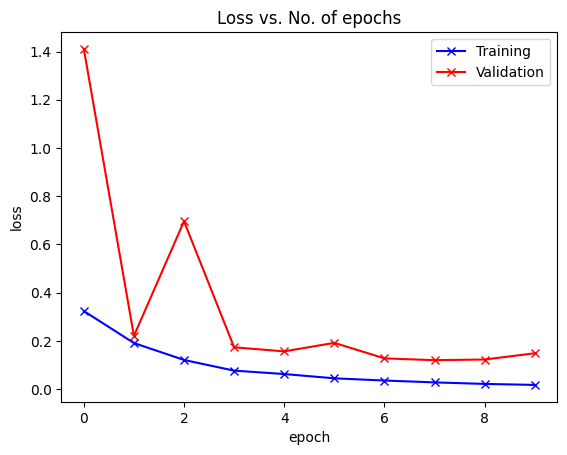

In [ ]:
plot_losses(history)

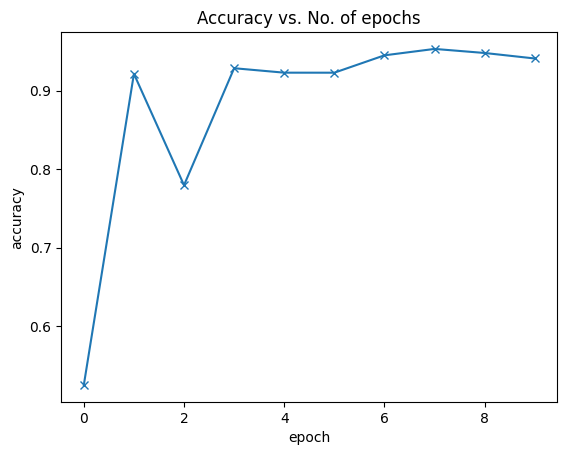

In [ ]:
plot_accuracies(history)

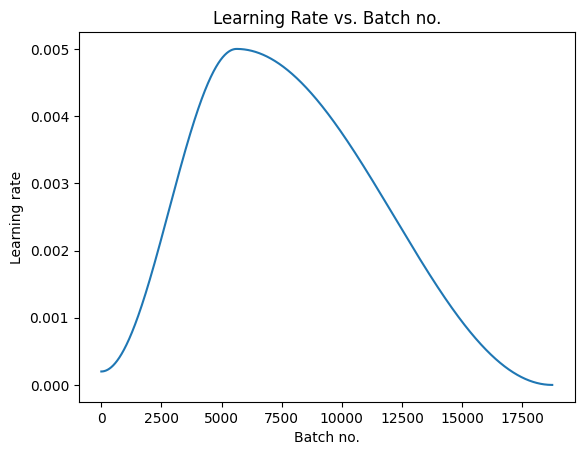

In [ ]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');
plot_lrs(history)

In [ ]:
print(train_ds.classes)

['DME', 'NB', 'NoJam', 'SingleAM', 'SingleChirp', 'SingleFM']


In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return classes[preds[0].item()]

Label: SingleChirp , Predicted: SingleChirp


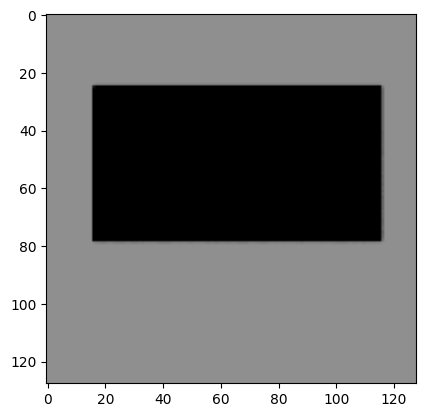

In [ ]:
img, label = test_ds[1002]
plt.imshow(img.permute(1, 2, 0))
print('Label:', classes[label], ', Predicted:', predict_image(img, model))

Label: SingleFM , Predicted: SingleFM


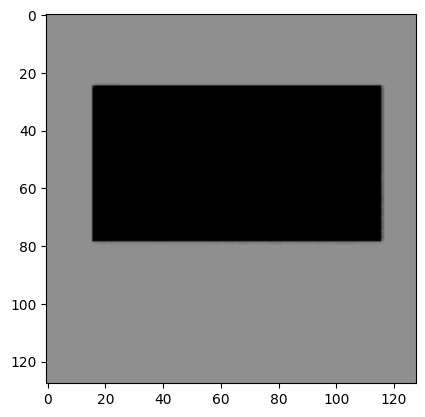

In [ ]:
img, label = test_ds[3001]
plt.imshow(img.permute(1, 2, 0));
print('Label:', classes[label], ', Predicted:', predict_image(img, model))